<a href="https://colab.research.google.com/github/7pandeys/AWS_DEPLOY/blob/main/FAISS_search_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***How to Use FAISS to Build Your First Similarity Search***

https://medium.com/loopio-tech/how-to-use-faiss-to-build-your-first-similarity-search-bf0f708aa772

#0. Setup

In [1]:
!pip install faiss-cpu
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 21.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.6 MB/s 
     |████████████████████████████████| 5.3 MB 46.4 MB/s 
     |████████████████████████████████| 1.3 MB 53.6 MB/s 
     |████████████████████████████████| 163 kB 47.7 MB/s 
     |████████████████████████████████| 7.6 MB 13.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=5032254bf5f1bd5e7a917602ec69033944d15a3daec19bc5c6928c754e723083
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


#1. Create a dataframe with the existing text and categories

In [11]:
import pandas as pd
data = [['where are your headquarters located?','location'],
        ['Throw my cellphone in the water','random'],
        ['Network Access Control?', 'networking'],
        ['Address','location']]

df = pd.DataFrame(data, columns = ['text', 'category'])
df.index += 1

In [6]:
df.head()

,text,category
1,where are your headquarters located?,location
2,Throw my cellphone in the water,random
3,Network Access Control?,networking
4,Address,location


#2. Create vectors from the text

In [12]:
from sentence_transformers import SentenceTransformer
text = df['text']
encoder = SentenceTransformer("paraphrase-mpnet-base-v2")
vectors = encoder.encode(text)

In [8]:
encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [13]:
vectors

array([[-0.00437615, -0.06387773, -0.11621019, ...,  0.09268746,
        -0.04782984, -0.05484063],
       [-0.01245354, -0.26505414, -0.04051865, ...,  0.14551324,
         0.13894193,  0.10772906],
       [-0.01477679,  0.05492553,  0.03377842, ...,  0.08851659,
        -0.14657766, -0.02152408],
       [-0.00393086,  0.12958993, -0.03536997, ...,  0.03184687,
        -0.11042545,  0.0257849 ]], dtype=float32)

In [10]:
text

1    where are your headquarters located?
2         Throw my cellphone in the water
3                 Network Access Control?
4                                 Address
Name: text, dtype: object

#3. Build a FAISS index from the vectors

In [14]:
import faiss

vector_dimension = vectors.shape[1]
index = faiss.IndexFlatL2(vector_dimension)
faiss.normalize_L2(vectors)
index.add(vectors)

#4. Create a search vector

In [16]:
import numpy as np

search_text = 'where is your office?'
search_vector = encoder.encode(search_text)
_vector = np.array([search_vector])
faiss.normalize_L2(_vector)

#5. Search

In [17]:
k = index.ntotal
distances, ann = index.search(_vector, k=k)

In [21]:
distances

array([[0.584873 , 1.1759505, 1.6442652, 1.9197674]], dtype=float32)

In [22]:
ann

array([[0, 3, 2, 1]])

#6. Sort

In [19]:
results = pd.DataFrame({'distances' : distances[0], 'ann' : ann[0]})

In [20]:
results

,distances,ann
0,0.584873,0
1,1.175951,3
2,1.644265,2
3,1.919767,1


#7. Get category for the search text

In [24]:
# join by: df1.ann = data.index
merge = pd.merge(results, df, left_on='ann', right_index=True)

In [25]:
merge

,distances,ann,text,category
0,0.584873,0,where are your headquarters located?,location
1,1.175951,3,Address,location
2,1.644265,2,Network Access Control?,networking
3,1.919767,1,Throw my cellphone in the water,random


In [26]:
labels =  df['category']
category = labels[ann[0][0]]

In [27]:
labels

0      location
1        random
2    networking
3      location
Name: category, dtype: object

In [28]:
category

'location'

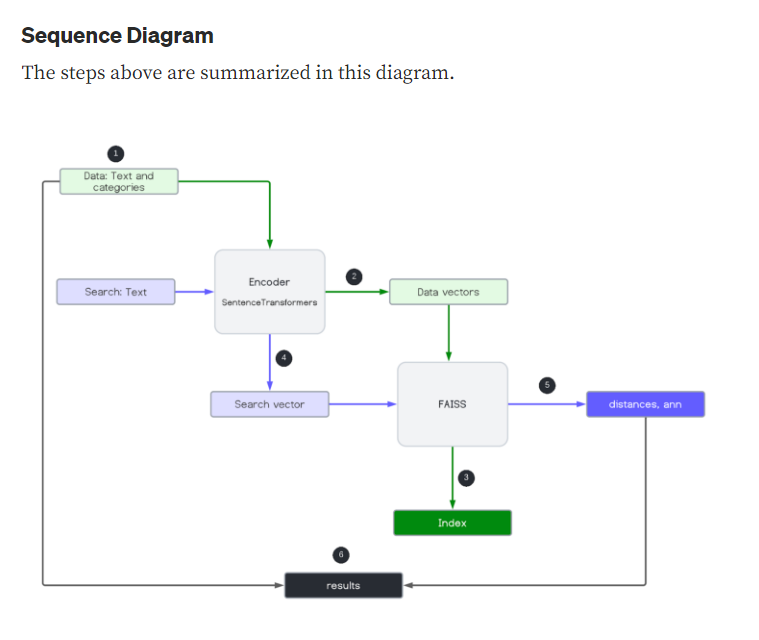